## Import Statements

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.linear_model import LogisticRegression
from sklearn_pandas import DataFrameMapper

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from scipy import sparse as sp


## Load the Data

In [16]:
df = pd.read_json('reviews.json')
df.head(5)

,Author,Author Name Length,Clean Title,Cleaned Text,Date,Is Guest,Negative Sentiment Score of Text,Negative Sentiment Score of Title,Positive Sentiment Score of Text,Positive Sentiment Score of Title,Rating,Review Length (char),SentimentWords,Text,Title,Words In Author Name,Words in Review
0,Scott,5,"[Five, Stars]","[great, little, flashlight, bright, buy]",2018-04-16,0,0.375,0.000,0.125,0.000,5,53,1,Great little flashlight bright will buy,Five Stars,1,8
1,ALFRED W,8,"[Works, good, on, 1.2, volt, Rechargeable, Ni-...","[nice, well, make, little, flashlight, work, g...",2018-04-15,0,0.375,0.000,2.250,1.375,5,90,1,Nice made little flashlight work good volt rec...,Works good on 1.2 volt Rechargeable Ni-Mh Batt...,2,14
10,CS McCulloh,11,"[Five, Stars]","[really, good, price]",2018-04-13,0,0.000,0.000,0.750,0.000,5,26,1,good price,Five Stars,2,5
100,Suki,4,"[Good, on, batteries]","[these, come, handy, hurricane, irma, live, or...",2018-03-28,0,0.875,0.000,1.375,0.750,5,439,1,came handy Hurricane Irma live Orlando lost po...,Good on batteries,1,81
1000,David H. Chiang,15,[awesome],"[seriously, amazing, price, use, 1, battery, a...",2013-12-25,0,0.625,0.125,1.375,0.875,5,161,1,amazing price using battery is fantastic have ...,awesome,3,28


## Visualize the Data

In [11]:
Y = df['Rating']

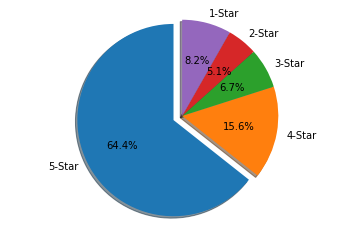

In [18]:
five_star = df[df['Rating']==5]
four_star = df[df['Rating']==4]
three_star = df[df['Rating']==3]
two_star = df[df['Rating']==2]
one_star = df[df['Rating']==1]

labels = '5-Star', '4-Star', '3-Star', '2-Star','1-Star'
sizes = [len(five_star), len(four_star), len(three_star), len(two_star), len(one_star)]
explode = (0.1, 0, 0, 0, 0)  # only "explode" 5 star

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

###### Shows Data is mostly 5-stars. Use Random Over Sampler to make sure training set does not always guess 5 stars. 

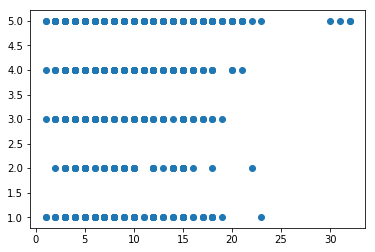

In [12]:
plt.scatter(df['Author Name Length'], Y)
plt.show()

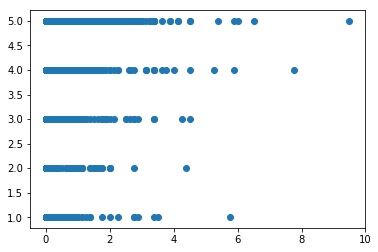

In [17]:
plt.scatter(df['Positive Sentiment Score of Text'], Y)
plt.show()

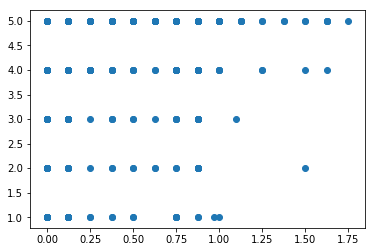

In [19]:
plt.scatter(df['Positive Sentiment Score of Title'], Y)
plt.show()


###### Positive Sentiment Score of Title doesn't not have a great correlation. Requires testing to see if it improves or worsens accuracy

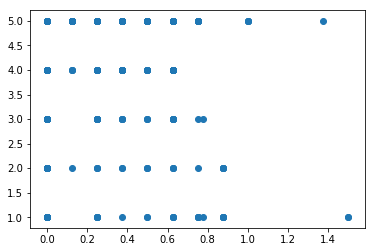

In [20]:
plt.scatter(df['Negative Sentiment Score of Title'], Y)
plt.show()


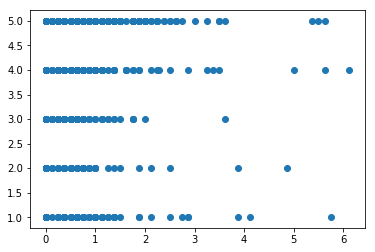

In [21]:
plt.scatter(df['Negative Sentiment Score of Text'], Y)
plt.show()

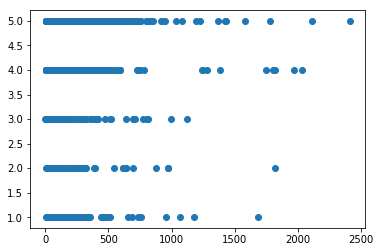

In [22]:
plt.scatter(df['Review Length (char)'], Y)
plt.show()

###### Above: Review Length by character seems to have some correlation to 5 star ratings

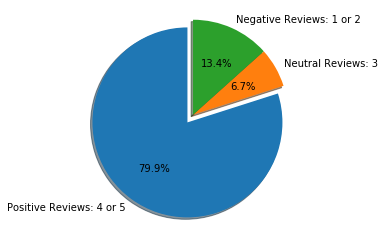

In [25]:
positive_reviews = df.loc[df['Rating'].isin([4,5])]
negative_reviews = df.loc[df['Rating'].isin([1,2])]
neutral_reviews = df.loc[df['Rating'] == 3]
len(positive_reviews)/len(df)

labels = 'Positive Reviews: 4 or 5', 'Neutral Reviews: 3', 'Negative Reviews: 1 or 2'
sizes = [len(positive_reviews), len(neutral_reviews), len(negative_reviews)]
explode = (0.1, 0, 0)  # only "explode" positives

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [26]:
numbers = {'one':1, 'two':2, 'three':3,'four':4, 'five':5}
df['Star In Title'] = df['Title'].apply(lambda x: True if 'star' in x.lower() and (num in x.lower() for num in numbers.keys()) else False)
def getNumbers(x):
    lowered = x.lower()
    retVal = 0
    if 'star' in lowered:
        for x in numbers.keys():
            if x in lowered:
                retVal = numbers[x]
    return retVal
df['Star Num'] = df['Title'].apply(getNumbers)
df[df['Star In Title']].count()
df['Star In Title'] = df['Star In Title'].apply(lambda x: 1 if x == True else 0)

In [53]:
df['Title and Body'] = df['Clean Title'] + df['Cleaned Text'] #Combine Title and Body for easier use if needed

In [ ]:
### Slice for TF-IDF

In [37]:
sliced = df[['Text', 'Rating', 'Star In Title', 'Star Num', 'Title', 'Author Name Length', 'Cleaned Text', 'Title and Body','Positive Sentiment Score of Text', 'Positive Sentiment Score of Title', 'Negative Sentiment Score of Text', 'Review Length (char)']]

## Data Learning


### Accuracy Function
###### Factors how close all predictions are to target instead of just Right or Wrong

In [62]:
def getAccuracy():
    test['Difference'] = test['Rating'] - test['predictions']
    sumOfDiff = 0
    for each in test['Difference']:
        sumOfDiff += abs(each)
        accuracy = 1-((sumOfDiff/len(test))/5) #gets average different among test and prediction and divides by 5. Then subtracts that from 1 to find the percent accuracy   
    print(accuracy)    
    


# Naive Bayes
### Model #1
### Mapper for NB
###### Max Features at approx. 1500 gives best result.

In [41]:
mapperNB = DataFrameMapper([
    (['Review Length (char)','Positive Sentiment Score of Text', 'Negative Sentiment Score of Text','Positive Sentiment Score of Title'], None),
    ('Text', TfidfVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words='english',
                               
                         )),
        ('Title', TfidfVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None, # English Stop-words hurt accuracy from title
                             ngram_range=(1,2),  #ngrams of monograms and bigrams improved score.
                         )),
])



### Naive Bayes using most features. And Tuned Hyperparams.
#### Averaged over 50 Trials

In [42]:

correct = []
for i in range(0,50):
    
    predictions = []
    
    train, test = train_test_split(sliced)
    train = train.reset_index(drop = True)
    test = test.reset_index(drop = True) 
    
    #sorting to predict stars in titles first
    test = test.sort_values('Star In Title', ascending = False).reset_index(drop = True)
    sub = test
    predictions += sub[sub['Star In Title'] == 1]['Star Num'].tolist()
    sub = sub[sub['Star In Title'] == 0].reset_index(drop = True)
    X = MultinomialNB()
    X.fit(mapperNB.fit_transform(train), train['Rating'])
    predictions += X.predict(mapperNB.transform(sub)).tolist()
    test['predictions'] = predictions

    correct += [len(test[test['predictions'] == test['Rating']])/len(test)]
    if i % 10 == 0:
        print(str(i) + ' Trials Completed')
        

0 Trials Completed
10 Trials Completed
20 Trials Completed
30 Trials Completed
40 Trials Completed


In [43]:
getAccuracy()

0.889024390244


# SVM
### Model #2

### Mapper for SVM

In [49]:
mapperSVM = DataFrameMapper([
    (['Author Name Length','Positive Sentiment Score of Title', 'Negative Sentiment Score of Text', 'Review Length (char)'], None),
    ('Text', TfidfVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words='english', 
                             ngram_range=(2,2)
                         )),
    ('Title', TfidfVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,
                              ngram_range=(1,2)
                             
                         )),
])


In [63]:
correct = []

for i in range(0,50):
    
    predictions = []
    
    train, test = train_test_split(sliced)
    train = train.reset_index(drop = True)
    test = test.reset_index(drop = True) 
    sm = RandomOverSampler(ratio = {1:400, 2:400, 3:400, 4:400})
    x_res, y_res = sm.fit_sample(mapperSVM.fit_transform(train), train['Rating'].values)
    #sorting to predict stars in titles first
    test = test.sort_values('Star In Title', ascending = False).reset_index(drop = True)
    sub = test
    predictions += sub[sub['Star In Title'] == 1]['Star Num'].tolist()
    sub = sub[sub['Star In Title'] == False].reset_index(drop = True)
    
    #run classifier on rest of not already classified data
    X = svm.LinearSVC()
    X.fit(x_res, y_res)
    predictions += X.predict(mapperSVM.transform(sub)).tolist()
    test['predictions'] = predictions

    correct += [len(test[test['predictions'] == test['Rating']])/len(test)]
    if i % 10 == 0:
        print(str(i) + ' Trials Completed')

0 Trials Completed
10 Trials Completed
20 Trials Completed
30 Trials Completed
40 Trials Completed


In [64]:
getAccuracy()

0.857317073171


In [57]:
for x in X.coef_:
    absMax = abs(x)
    print(np.argmax(absMax))
    print(max(absMax))
    
model = mapperSVM.fit_transform(train)

tf = TfidfVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,
                             vocabulary=None)

gg = tf.fit(train['Text'])
feature_names = gg.get_feature_names()



1857
1.44964496025
2737
1.35007333802
363
1.31535100021
1718
1.25448209578
1741
1.38732979456


##### Looking at common words and their weights for each rating class

In [58]:
for i in range(0,5):
    print('class ' + str(i + 1))
    print(sorted(zip(feature_names, X.coef_[i, :]), key=lambda x: np.abs(x[1]), reverse=True)[:10])

class 1
[('worthless', 0.90378896833868116), ('illuminates', 0.76133321121081199), ('babies', 0.67754893081146061), ('whatever', 0.67558901611835576), ('operates', 0.66282980330444208), ('dollar', 0.58906453753087729), ('tough', 0.51735910482409664), ('diameter', 0.38861004797709442), ('harbor', 0.35788234807147062), ('different', 0.33024621432363721)]
class 2
[('tend', 0.9330779347432081), ('focusable', 0.52828632075193804), ('spreads', 0.47092825183621007), ('own', 0.4602451849283628), ('package', 0.45721368439473875), ('flashlights', 0.43638584690361493), ('came', 0.43638017219337838), ('concentrated', 0.42214105183863576), ('described', 0.40154911414823891), ('double', 0.385927689969914)]
class 3
[('doa', -1.3153510002060218), ('covers', -1.216497563832287), ('suv', 1.1739686079649574), ('words', 0.82730803156928789), ('thank', 0.65146117872860509), ('survival', 0.52980040497291303), ('lot', 0.49715556500315888), ('swear', 0.47899116333389102), ('wonder', 0.47207954690318021), ('bu